In [105]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization,Dropout,GlobalAveragePooling2D, MaxPooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import EfficientNetB0

import numpy as np
from glob import glob

In [106]:
batch = 32
img_height = 180
img_width = 180

#train_path = 'C:/Users/athul/Downloads/IP J comp/Train'
#test_path = 'C:/Users/athul/Downloads/IP J comp/Test'

#train_path = 'C:/Users/athul/Downloads/IP J comp/Laplacian/Train'
#test_path = 'C:/Users/athul/Downloads/IP J comp/Laplacian/Test'

train_path = 'C:/Users/athul/Downloads/IP J comp/Gaussian/Train'
test_path = 'C:/Users/athul/Downloads/IP J comp/Gaussian/Test'

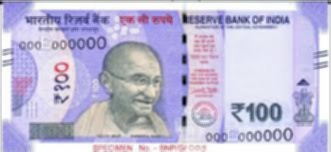

In [107]:
import PIL, pathlib
train_path = pathlib.Path(train_path)
onehundred = list(train_path.glob('1Hundrednote/*'))
PIL.Image.open(str(onehundred[5]))

In [108]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                train_path,
  seed=123,color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch)
print(train_ds)

Found 153 files belonging to 7 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [109]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
#  validation_split=0.1,
 # subset="validation",
  seed=123,color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch)

Found 42 files belonging to 7 classes.


In [110]:
class_names = train_ds.class_names
print(train_ds)
print(class_names)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['1Hundrednote', '2Hundrednote', '2Thousandnote', '5Hundrednote', 'Fiftynote', 'Tennote', 'Twentynote']


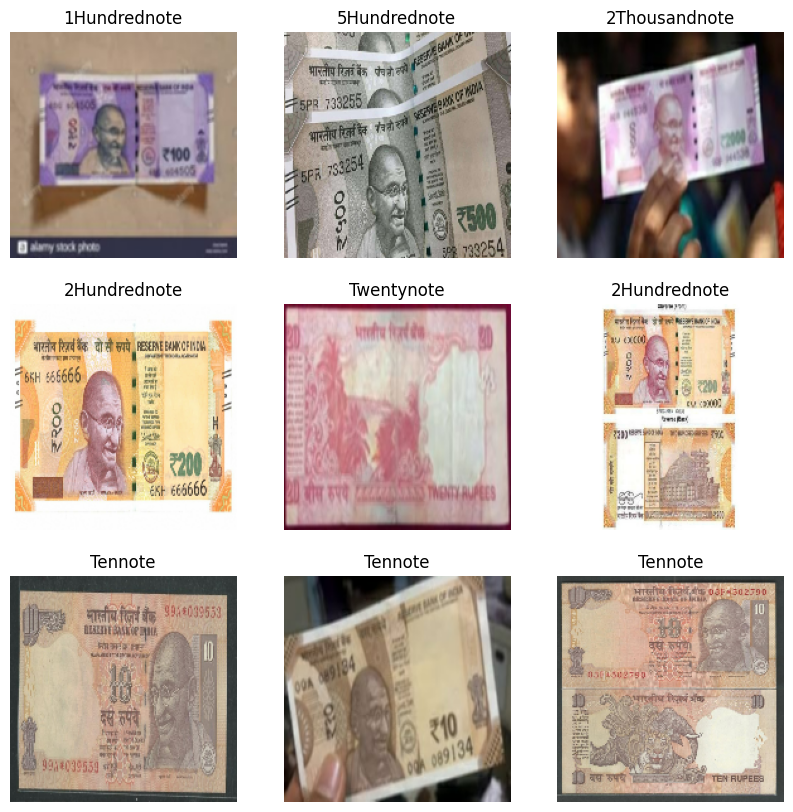

In [112]:
#Data Visualization
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #laplacian=cv2.Laplacian(images[i].numpy().astype("uint8"),cv2.CV_64F)
    #plt.imshow(laplacian)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [113]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [114]:
#normalize data by using a rescaling layer

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.16651167 1.0


In [115]:
Classifier=Sequential()

Classifier.add(layers.experimental.preprocessing.Rescaling(1./255,
      input_shape=(img_height, img_width, 3)))

Classifier.add(Conv2D(32,(3,3),
                      input_shape=(img_height,img_width,3), 
                      activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))

Classifier.add(Conv2D(32,(3,3),activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))

Classifier.add(Flatten())

Classifier.add(Dense(units = 128, activation = 'relu'))
Classifier.add(Dense(units = 7, activation = 'softmax'))

In [116]:
Classifier.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [117]:
Classifier.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 59168)           

In [118]:
from PIL import _imaging
from PIL import Image
#fit the classifier
epochs = 30
r = Classifier.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
)

Epoch 1/30
5/5 [==============================] - 3s 462ms/step - loss: 4.8842 - accuracy: 0.1438 - val_loss: 2.1857 - val_accuracy: 0.1429
Epoch 2/30
5/5 [==============================] - 2s 413ms/step - loss: 1.9284 - accuracy: 0.2026 - val_loss: 1.7808 - val_accuracy: 0.3333
Epoch 3/30
5/5 [==============================] - 2s 423ms/step - loss: 1.5819 - accuracy: 0.3922 - val_loss: 1.3813 - val_accuracy: 0.4048
Epoch 4/30
5/5 [==============================] - 2s 411ms/step - loss: 1.1187 - accuracy: 0.5948 - val_loss: 1.2251 - val_accuracy: 0.4524
Epoch 5/30
5/5 [==============================] - 2s 411ms/step - loss: 0.7626 - accuracy: 0.7778 - val_loss: 1.3504 - val_accuracy: 0.4286
Epoch 6/30
5/5 [==============================] - 2s 433ms/step - loss: 0.5498 - accuracy: 0.8301 - val_loss: 0.8525 - val_accuracy: 0.6905
Epoch 7/30
5/5 [==============================] - 2s 430ms/step - loss: 0.3975 - accuracy: 0.8693 - val_loss: 0.9332 - val_accuracy: 0.6905
Epoch 8/30
5/5 [====

In [119]:
mean_val = (sum(r.history['val_accuracy']))/(len(r.history['val_accuracy']))
print('mean_test_accuracy: ', mean_val)

mean_test_accuracy:  0.6865079308549563


In [120]:
mean_train = (sum(r.history['accuracy']))/(len(r.history['accuracy']))
print('mean_train_accuracy: ', mean_train)

mean_train_accuracy:  0.8891067564487457


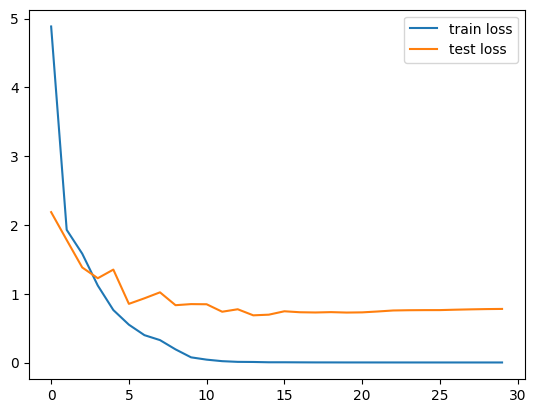

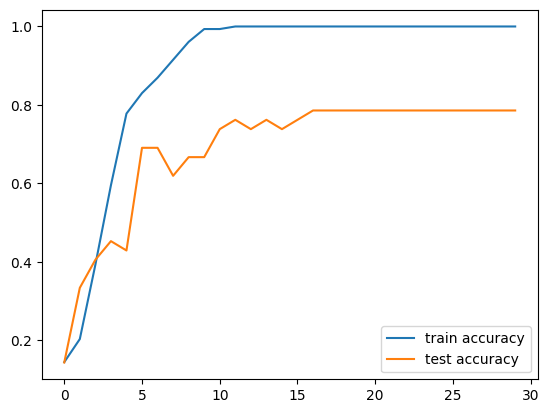

In [121]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [122]:
#Data Augmentation to reduce overfitting

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [123]:
Classifier=Sequential()

Classifier.add(data_augmentation)
Classifier.add(layers.experimental.preprocessing.Rescaling(1./255,
      input_shape=(img_height, img_width, 3)))

Classifier.add(Conv2D(32,(3,3),
                      input_shape=(img_height,img_width,3), 
                      activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))

Classifier.add(Conv2D(32,(3,3),activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))
Classifier.add(layers.Dropout(0.2))

Classifier.add(Flatten())

Classifier.add(Dense(units = 128, activation = 'relu'))
Classifier.add(Dense(units = 7, activation = 'softmax'))

In [124]:
Classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
Classifier.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                

In [126]:
epochs = 30
r = Classifier.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/30
5/5 [==============================] - 5s 533ms/step - loss: 6.3209 - accuracy: 0.1046 - val_loss: 2.1443 - val_accuracy: 0.1667
Epoch 2/30
5/5 [==============================] - 3s 510ms/step - loss: 1.9596 - accuracy: 0.2092 - val_loss: 1.8950 - val_accuracy: 0.2381
Epoch 3/30
5/5 [==============================] - 3s 549ms/step - loss: 1.8212 - accuracy: 0.2549 - val_loss: 1.6010 - val_accuracy: 0.3333
Epoch 4/30
5/5 [==============================] - 3s 550ms/step - loss: 1.5099 - accuracy: 0.4314 - val_loss: 1.3462 - val_accuracy: 0.3810
Epoch 5/30
5/5 [==============================] - 3s 552ms/step - loss: 1.2618 - accuracy: 0.5490 - val_loss: 1.0836 - val_accuracy: 0.5476
Epoch 6/30
5/5 [==============================] - 3s 512ms/step - loss: 1.1206 - accuracy: 0.5752 - val_loss: 0.9420 - val_accuracy: 0.5714
Epoch 7/30
5/5 [==============================] - 2s 493ms/step - loss: 0.9642 - accuracy: 0.6209 - val_loss: 1.0050 - val_accuracy: 0.5000
Epoch 8/30
5/5 [====

In [127]:
mean_val = (max(r.history['val_accuracy']))
print('mean_test_accuracy: ', mean_val)
print('\n')
mean_train = (max(r.history['accuracy']))
print('mean_train_accuracy: ', mean_train)

mean_test_accuracy:  0.8095238208770752


mean_train_accuracy:  0.9477124214172363


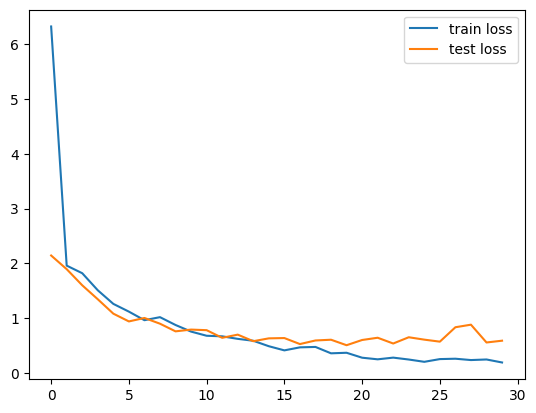

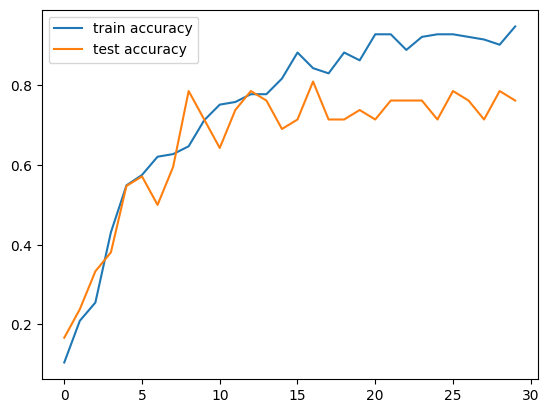

In [128]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [129]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(180,180,3))

Classifier=Sequential()

Classifier.add(effnet)

Classifier.add(GlobalAveragePooling2D())

Classifier.add(Flatten())

Classifier.add(Dense(512,activation='relu'))
Classifier.add(Dense(128,activation='relu'))

Classifier.add(Dense(64,activation='relu'))
Classifier.add(Dense(32,activation='relu'))

Classifier.add(Dropout(0.5))

Classifier.add(Dense(units = 32, activation = 'relu'))
Classifier.add(Dense(units = 7, activation = 'softmax'))

In [130]:
Classifier.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [131]:
Classifier.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_11 (Flatten)        (None, 1280)              0         
                                                                 
 dense_34 (Dense)            (None, 512)               655872    
                                                                 
 dense_35 (Dense)            (None, 128)               65664     
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                     

In [132]:
from PIL import _imaging
from PIL import Image
#fit the classifier
epochs = 25
r = Classifier.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
)

Epoch 1/25
5/5 [==============================] - 28s 4s/step - loss: 1.9156 - accuracy: 0.1961 - val_loss: 1.8816 - val_accuracy: 0.1667
Epoch 2/25
5/5 [==============================] - 16s 3s/step - loss: 1.7422 - accuracy: 0.3007 - val_loss: 1.6982 - val_accuracy: 0.2381
Epoch 3/25
5/5 [==============================] - 14s 3s/step - loss: 1.5433 - accuracy: 0.4118 - val_loss: 1.5992 - val_accuracy: 0.3810
Epoch 4/25
5/5 [==============================] - 14s 3s/step - loss: 1.3178 - accuracy: 0.4967 - val_loss: 1.3446 - val_accuracy: 0.5476
Epoch 5/25
5/5 [==============================] - 14s 3s/step - loss: 1.0931 - accuracy: 0.5686 - val_loss: 1.1344 - val_accuracy: 0.6190
Epoch 6/25
5/5 [==============================] - 14s 3s/step - loss: 0.8239 - accuracy: 0.7059 - val_loss: 1.1055 - val_accuracy: 0.6667
Epoch 7/25
5/5 [==============================] - 15s 3s/step - loss: 0.6392 - accuracy: 0.7582 - val_loss: 1.4172 - val_accuracy: 0.7143
Epoch 8/25
5/5 [==================

In [133]:
mean_val = (max(r.history['val_accuracy']))
print('mean_test_accuracy: ', mean_val)

mean_test_accuracy:  0.9523809552192688


In [134]:
mean_train = (max(r.history['accuracy']))

print('mean_train_accuracy: ', mean_train)

mean_train_accuracy:  0.9738562107086182


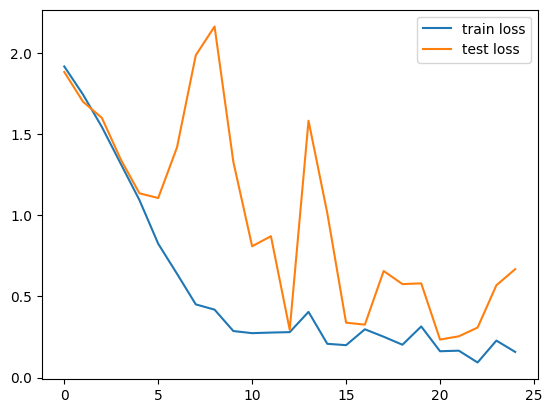

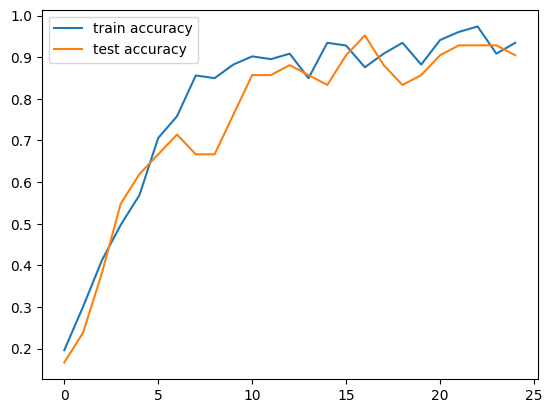

In [135]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

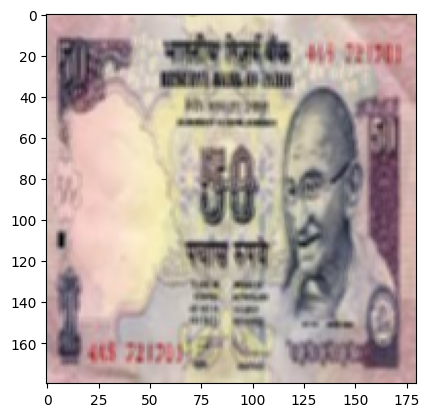

In [157]:
#Use classifier to run prediction on any new image

from tensorflow.keras.preprocessing import image
img = image.load_img('C:/Users/athul/Downloads/IP J comp/Test/Fiftynote/28.jpg',
                       target_size=(img_height,img_width))
img=cv2.GaussianBlur(np.array(img),(3,3),cv2.BORDER_DEFAULT)
plt.imshow(img)

In [158]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(Classifier.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 52ms/step


array([4], dtype=int64)

In [159]:
prediction = class_names[result[0]]
prediction

'Fiftynote'